In [1]:
import pandas as pd
import numpy as np

from pipeline.feature_engineering import apply_PCA
from pipeline.ANN import build_ANN
from pipeline.training import train_and_save, plot_history
from pipeline.preprocessing import preprocess_data
from pipeline.hyperparam_tuning import run_hyperband_tuner
from pipeline.data_augmentation import augment_data_simple, augment_data_smoter
from pipeline.data_visualisation import plot_correlation, plot_feature_distributions, plot_target_distribution

In [2]:
!pip install xlrd --quiet
all_df = pd.read_excel('data/TrainDataset2025.xls', engine='xlrd')
all_df.head()

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.0,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.0,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.0,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.0,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


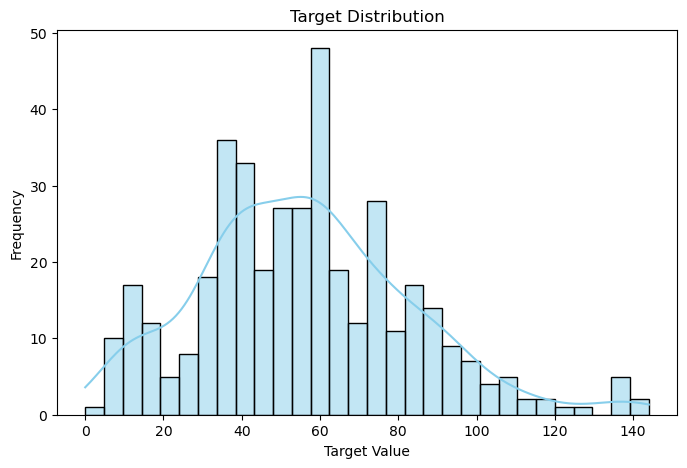

In [3]:
#visualising target distribution
all_df = all_df.drop(columns=['ID'])  
df = all_df.replace(999, np.nan)
outcomes = ['RelapseFreeSurvival (outcome)', 'pCR (outcome)']
target = 'RelapseFreeSurvival (outcome)'
features = df.drop(columns=outcomes)

plot_target_distribution(df[target])

In [4]:
#data pre-processing
X_train, X_test, y_train, y_test, imputer, scaler = preprocess_data(df, outcomes, target)

In [6]:
#data augmentation 
X_train_aug, y_train_aug = augment_data_smoter(X_train, y_train)

Original train size: 320
Augmented train size: 592


In [8]:
#feature engineering with and without selective PCA
mandatory_indices = [1,3,10]

#non-PCA
X_train_npca = X_train_aug
X_test_npca  = X_test
input_dim_npca = X_train_npca.shape[1]

#PCA: 95%
X_train_pca, X_test_pca, pca, n_components = apply_PCA(X_train_aug, X_test, mandatory_indices,0.95)
input_dim_pca = X_train_pca.shape[1]

#PCA: 90%
X_train_pca2, X_test_pca2, pca2, n_components2 = apply_PCA(X_train_aug, X_test, mandatory_indices, 0.90)
input_dim_pca2 = X_train_pca2.shape[1]

In [11]:
#hyperparam tuning

npca_tuner = run_hyperband_tuner(build_ANN, input_dim_npca ,X_train_npca, y_train_aug, 'NPCA_AUG3_Tuner')

best_npca = npca_tuner.get_best_models(1)[0]
best_npca_hp = npca_tuner.get_best_hyperparameters(1)[0]


Trial 90 Complete [00h 00m 20s]
val_mae: 37.85948181152344

Best val_mae So Far: 23.71479034423828
Total elapsed time: 00h 11m 19s


In [13]:
pca_tuner = run_hyperband_tuner(build_ANN, input_dim_pca, X_train_pca, y_train_aug, 'PCA_AUG3_Tuner')

best_pca = pca_tuner.get_best_models(1)[0]
best_pca_hp = pca_tuner.get_best_hyperparameters(1)[0]

Trial 91 Complete [00h 00m 20s]
val_mae: 43.94023132324219

Best val_mae So Far: 25.047391891479492
Total elapsed time: 00h 12m 54s


In [14]:
pca2_tuner = run_hyperband_tuner(build_ANN, input_dim_pca2, X_train_pca2, y_train_aug, 'PCA2_AUG3_Tuner')

best_pca2 = pca2_tuner.get_best_models(1)[0]
best_pca2_hp = pca2_tuner.get_best_hyperparameters(1)[0]

Trial 90 Complete [00h 00m 20s]
val_mae: 43.7232666015625

Best val_mae So Far: 25.4855899810791
Total elapsed time: 00h 14m 00s


In [15]:
%load_ext tensorboard
%tensorboard --logdir pipeline/logs

Reusing TensorBoard on port 6006 (pid 25732), started 8:35:27 ago. (Use '!kill 25732' to kill it.)

In [16]:
y_train_aug = np.array(y_train_aug).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [17]:
#training models on full training set and evaluating on test set

history_npca, metrics_npca = train_and_save(
    'npca_AUG3',
    best_npca,
    best_npca_hp,
    X_train_npca,
    y_train_aug,
    X_test_npca,
    y_test
)

history_pca, metrics_pca = train_and_save(
    'pca_AUG3',
    best_pca,
    best_pca_hp,
    X_train_pca,
    y_train_aug,
    X_test_pca,
    y_test
)

history_pca2, metrics_pca2 = train_and_save(
    'pca2_AUG3',
    best_pca2,
    best_pca2_hp,
    X_train_pca2,
    y_train_aug,
    X_test_pca2,
    y_test
)

print("Non-PCA Test MAE:", metrics_npca['test_mae'])
print("PCA (95%) Test MAE:", metrics_pca['test_mae'])
print("PCA (90%) Test MAE:", metrics_pca2['test_mae'])

Epoch 1/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 623.9751 - mae: 19.7740 - val_loss: 1119.3036 - val_mae: 26.4050
Epoch 2/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 558.7418 - mae: 18.6121 - val_loss: 1081.3689 - val_mae: 25.8055
Epoch 3/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 546.3734 - mae: 18.4857 - val_loss: 1352.1202 - val_mae: 26.4433
Epoch 4/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 535.8273 - mae: 18.3335 - val_loss: 1005.2370 - val_mae: 24.6646
Epoch 5/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 556.9390 - mae: 18.1460 - val_loss: 1223.5321 - val_mae: 26.3954
Epoch 6/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 513.0233 - mae: 17.9495 - val_loss: 1353.4761 - val_mae: 25.4045
Epoch 7/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 539.2660 - mae: 18.0867 - val_loss: 1050.4860 - val_mae: 26.0780
Epoch 8/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 486.9059 - mae: 17.2940 - val_loss: 1195.0081 - val_mae: 26.1018
Epoch 9/

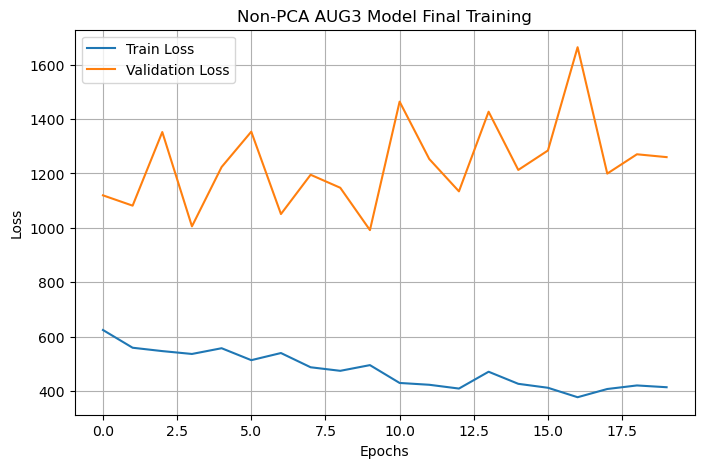

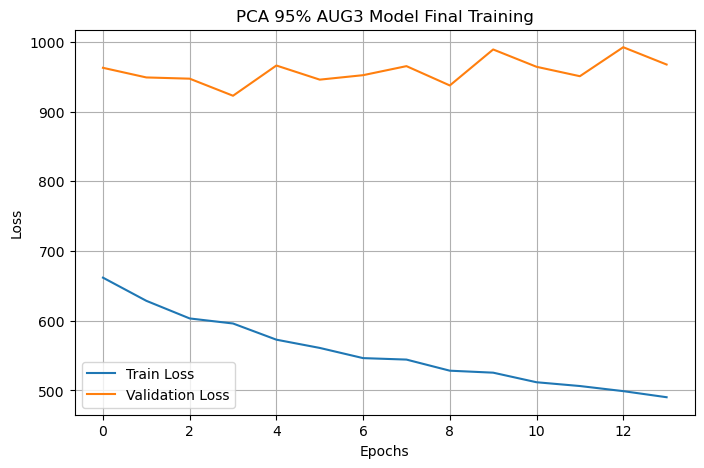

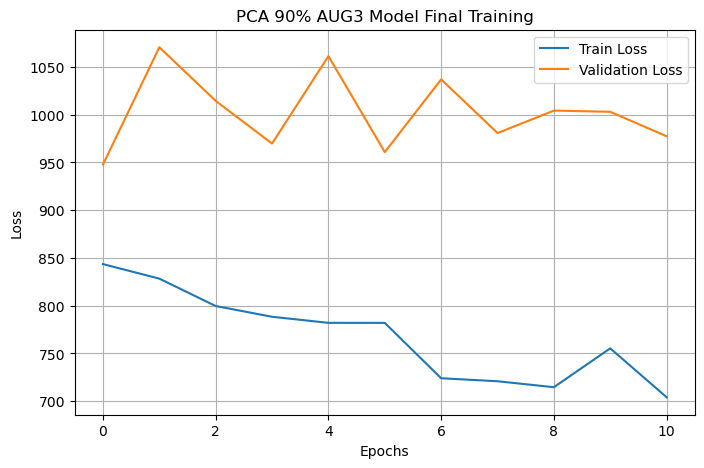

In [18]:
#visualising training process

plot_history('npca_AUG3', history_npca, 'Non-PCA AUG3 Model Final Training')
plot_history('pca_AUG3', history_pca, 'PCA 95% AUG3 Model Final Training')
plot_history('pca2_AUG3', history_pca2, 'PCA 90% AUG3 Model Final Training')
